# TarDiff - génération ciblée par influence 

Ce notebook est mon implémentation personnelle de l’article [TarDiff: Target-Oriented Diffusion Guidance for Synthetic Electronic Health Record Time Series Generation](https://arxiv.org/abs/2504.17613) de Bowen Deng et al., 2023 dans le cadre de mon cours de simulation et modèles génératifs enseigné par Sylvain Le Corff. 

Le but est de maitriser en profondeur l'article en l'implémentant sur un jeu de données simple (2D) avant de l'appliquer sur un jeu de données réel (ECG) et de challenger la performance / pertinence des différents choix d'implémentations et d'hyperparamètres.  

## 1. Introduction

### Contexte et objectif

Les modèles de diffusion permettent de générer des séries temporelles médicales synthétiques (EHR), utiles pour pallier la rareté des données et les contraintes de confidentialité.  
Cependant, la plupart des approches existantes optimisent uniquement le **réalisme** des données générées, sans se soucier de leur **utilité pour les tâches cliniques downstream** (ex. prédiction de mortalité ou d’admission en réanimation).

Résultat : les données synthétiques reproduisent surtout des trajectoires fréquentes, et apportent peu d’information pour les cas rares mais cliniquement critiques.

Or, en pratique clinique, les données sont fortement **déséquilibrées** : la majorité des patients ne présentent pas l’événement d’intérêt (ex. décès, admission en réanimation, complications sévères...). C'est une bonne nouvelle :), mais les modèles génératifs tendent alors à sur-représenter des trajectoires fréquentes. 

Donc il est crucial de générer des données synthétiques qui soient non seulement réalistes, mais aussi **utiles** pour les tâches cliniques spécifiques.

### Idée clé de TarDiff

**TarDiff** (Target-Oriented Diffusion) propose de guider la génération de données synthétiques en fonction de leur impact sur une tâche cible.

Pour cela :
- on mesure, via des **fonctions d’influence**, l’effet qu’un échantillon synthétique aurait sur les performances d’un modèle prédictif donné,
- ces scores d’influence sont utilisés comme signal de guidage dans le processus inverse de diffusion.

La génération est ainsi orientée vers des échantillons qui sont :
- plausibles d’un point de vue médical,
- explicitement bénéfiques pour la tâche clinique considérée.

### Plan du notebook

1. Introduction
2. Présentation formelle de la méthode TarDiff
3. Implémentation de TarDiff sur un jeu de données 2D simple
4. Analyse de la méthode sur un jeu simple biaisé
5. Application à des données ECG réelles 
6. Discussion et perspectives

## 2. Présentation formelle de la méthode TarDiff

L'idée centrale de TarDiff est de transformer un problème de génération (imiter la distribution des données) en un problème de génération orientée tâche : on guide la diffusion pour produire des exemples synthétiques qui, s'ils étaient ajoutés au train, amélioreraient la performance d'un modèle downstream sur des données i.i.d. non vues.

### 2.1 Influence : mesurer l'utilité d'un point synthétique pour une tâche

On fixe une tâche downstream $T$ avec une loss $\ell_T(\cdot;\phi)$ et un modèle $f_\phi$. Sur le dataset d'entraînement

$$
\mathcal{D}_{\text{train}}=\{(x_i,y_i)\}_{i=1}^n,
$$

on définit les paramètres optimaux :

$$
\phi^*=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}}\ell_T(x_i,y_i;\phi).
$$

On considère ensuite un échantillon synthétique candidat $\hat{z}=(x,y)$ que l'on ajouterait au train. Le nouvel optimum devient :

$$
\phi^{\hat{z}}=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}\cup\{\hat{z}\}}\ell_T(x_i,y_i;\phi).
$$

Pour une donnée de test $(x',y')$, on regarde le changement de loss induit par l'ajout de $\hat{z}$ :

$$
H(x,y,x',y')=\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*).
$$

Si $P$ désigne la distribution i.i.d. des données futures, l'influence est l'amélioration attendue sur cette distribution :

$$
\Delta L_T(\hat{z})\;:=\;
-\mathbb{E}_{(x',y')\sim P}\big[\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*)\big].
$$

Objectif conceptuel :

$$
\hat{z}^*=\arg\max_{\hat{z}}\Delta L_T(\hat{z}),
$$

c'est-à-dire générer des points qui maximisent le gain attendu en généralisation.

**Intuition.** On ne veut pas seulement ressembler aux données. On veut des points qui, une fois ajoutés au train, font baisser la loss sur des exemples i.i.d. représentatifs, en pratique approximés par un split de validation servant de guidance set.

### 2.2 Du critère d'influence au guidage de la diffusion


On part d'un modèle de diffusion conditionnel par $y$. À l'étape $t$ du reverse process, le DDPM définit :

$$
p_\theta(x_{t-1}\mid x_t,y)
=\mathcal{N}\big(\mu_\theta(x_t,y,t),\Sigma_\theta(t)\big).
$$

Principe général du *guidage* en diffusion : au lieu d'échantillonner autour de la moyenne $\mu_\theta$ telle quelle, on la **décale légèrement** dans une direction qui augmente un critère d'intérêt $S(x_t,y)$. Comme l'échantillonnage est gaussien, ce décalage suffit à **biaiser la trajectoire de débruitage** vers des régions de l'espace où ce critère est plus élevé.

TarDiff applique ce principe avec un critère orienté tâche. Ici, le critère n'est pas une probabilité de classe, mais l'influence $\Delta L_T(\hat z)$, qui mesure à quel point un point synthétique $\hat z=(x,y)$ améliorerait la performance du modèle downstream sur des données i.i.d. À l'étape $t$, on interprète $\hat z_t=(x_t,y)$ comme un prototype de l'échantillon final, et on guide la diffusion vers les régions où cette influence est grande en ajoutant son gradient à la moyenne :

$$
\tilde{\mu}_t
=\mu_\theta(x_t,y,t)+w\,\nabla_{x_t}\Delta L_T(\hat{z}_t),
\qquad \hat{z}_t=(x_t,y),
$$

puis on échantillonne :

$$
x_{t-1}\sim \mathcal{N}\big(\tilde{\mu}_t,\Sigma_\theta(t)\big).
$$

Ainsi, $\nabla_{x_t}\Delta L_T(\hat z_t)$ indique la direction qui augmente le plus l'utilité attendue du futur échantillon pour la tâche, tandis que $w$ contrôle l'intensité de ce biais par rapport au débruitage standard.

### 2.3 Estimation pratique : cache de gradients et terme de guidage


Calculer exactement $\Delta L_T(\hat{z})$ est intractable car il faudrait réentraîner $f_\phi$ pour chaque $\hat{z}$. TarDiff utilise une approximation de type influence function : l'effet d'ajouter $\hat{z}$ sur la loss d'un point $(x_g,y_g)$ dépend de l'alignement de leurs gradients.

On introduit un guidance set

$$
\mathcal{D}_{\text{guide}}=\{(x_g,y_g)\}_{g=1}^N,
$$

supposé i.i.d. de $P$. On agrège une fois pour toutes les gradients du downstream entraîné :

$$
G \;\triangleq\;
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

À des constantes de normalisation et de signe près, l'influence d'un candidat $\hat{z}$ est alors :

$$
\Delta L_T(\hat{z})\approx
\nabla_\phi \ell_T(x,y;\phi^*)\cdot G.
$$

Le signal de guidage au temps $t$ devient :

$$
J_t
\;\triangleq\;
\nabla_{x_t}\Big(
\nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
\Big).
$$

### 2.4 Algorithme (pipeline TarDiff)

1. **Pré-entraîner le modèle downstream**

$$
\phi^*=\arg\min_\phi
\sum_{(x,y)\in \mathcal{D}_{\text{train}}}
\ell_T(x,y;\phi).
$$

2. **Calculer le cache de gradients**

$$
G \leftarrow
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

3. **Sampling par diffusion guidée**

   Initialiser $x_T\sim\mathcal{N}(0,I)$.  
   Pour $t=T,\dots,1$ :
   
   $$
   \mu_t \leftarrow \mu_\theta(x_t,y,t),
   $$
   
   $$
   J_t \leftarrow
   \nabla_{x_t}\Big(
   \nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
   \Big),
   $$
   
   $$
   \tilde{\mu}_t \leftarrow \mu_t + w\,J_t,
   $$
   
   $$
   x_{t-1}\sim \mathcal{N}(\tilde{\mu}_t,\Sigma_\theta(t)).
   $$
   
   Retourner l'échantillon synthétique $\hat{z}=(x_0,y)$.


## 3. Données simulées : toy Gaussienne 2D

L’objectif de cette partie est de mettre en place un **cadre jouet contrôlé** pour valider le pipeline TarDiff sur un cas simple et interprétable.

### 3.1 Vue d'ensemble du protocole

- **Distribution** : mélange de deux gaussiennes 2D.
- **Labels** : $y \in \{0,1\}$ selon la composante.
- **Split** : train / val (guide) / test.
- **Tâche downstream** : classification binaire (Accuracy, AUROC, AUPRC).

Ici, on se limite au cas **équilibré (50/50)**.

### 3.2 Génération du dataset 

On génère un jeu de données de deux gaussiennes 2D équilibré et un **split train/guide/test**.

In [29]:
# --- Imports & config ---
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [30]:
from sklearn.datasets import make_blobs
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons

@dataclass
class ToyConfig:
    n_samples: int = 10000
    minority_ratio: float = 0.5
    batch_size: int = 128
    test_samples: int = 2000


def make_toy_gaussians(cfg: ToyConfig):
    n_min = int(cfg.n_samples * cfg.minority_ratio)
    n_maj = cfg.n_samples - n_min

    # Training distribution
    X_maj, y_maj = make_blobs(n_samples=n_maj, centers=[[0.0, 0.0]], cluster_std=1)
    # Minority class: mixture of two Gaussians
    # - 80% from N([2,0], I)
    # - 20% from N([0.7,0], 0.9 I)
    comps = np.random.choice([0, 1], size=n_min, p=[0.8, 0.2])
    mean0 = np.array([2.0, 0.0])
    mean1 = np.array([0.7, 0.0])
    cov0 = np.eye(2) * 1.0
    cov1 = np.eye(2) * 0.9

    X_min = np.zeros((n_min, 2))
    n0 = int((comps == 0).sum())
    n1 = n_min - n0
    if n0 > 0:
        X_min[comps == 0] = np.random.multivariate_normal(mean0, cov0, size=n0)
    if n1 > 0:
        X_min[comps == 1] = np.random.multivariate_normal(mean1, cov1, size=n1)

    y_min = np.ones(n_min, dtype=int)
    y_maj[:] = 0
    y_min[:] = 1

    X = np.vstack([X_maj, X_min])
    y = np.hstack([y_maj, y_min])

    # global normalization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.long).to(DEVICE)

    # Split train/guide
    n_train = int(0.8 * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_guide, y_guide = X[n_train:], y[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    guide_loader = DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

    # Test set 
    X_maj_t, y_maj_t = make_blobs(n_samples=cfg.test_samples // 2, centers=[[0.0, 0.0]], cluster_std=1)
    # minority test set: same mixture as training (80% N([2,0], I), 20% N([0.7,0], 0.9 I))
    n_min_t = cfg.test_samples // 2
    comps_t = np.random.choice([0, 1], size=n_min_t, p=[0.8, 0.2])
    X_min_t = np.zeros((n_min_t, 2))
    n0_t = int((comps_t == 0).sum())
    n1_t = n_min_t - n0_t
    if n0_t > 0:
        X_min_t[comps_t == 0] = np.random.multivariate_normal(mean0, cov0, size=n0_t)
    if n1_t > 0:
        X_min_t[comps_t == 1] = np.random.multivariate_normal(mean1, cov1, size=n1_t)
    y_min_t = np.ones(n_min_t, dtype=int)
    y_maj_t[:] = 0
    y_min_t[:] = 1
    X_test = np.vstack([X_maj_t, X_min_t])
    y_test = np.hstack([y_maj_t, y_min_t])
    X_test = (X_test - mean) / std

    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    stats = dict(mean=mean, std=std)
    return train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats

def make_imbalanced_moons(cfg: ToyConfig):
    """
    Dataset 2D non-linéaire et fortement déséquilibré (95/5).
    Classe 0 : grosse lune (make_moons)
    Classe 1 : petit cluster proche de la classe 0
    """

    minority_ratio = 0.05
    n_min = int(cfg.n_samples * minority_ratio)
    n_maj = cfg.n_samples - n_min

    # Majority class: moon-shaped distribution
    X_maj, _ = make_moons(n_samples=n_maj, noise=0.1)
    y_maj = np.zeros(n_maj, dtype=int)

    # Minority class: small cluster near the moon
    mean_min = np.array([0.5, 0.2])
    cov_min = np.eye(2) * 0.02
    X_min = np.random.multivariate_normal(mean_min, cov_min, size=n_min)
    y_min = np.ones(n_min, dtype=int)

    X = np.vstack([X_maj, X_min])
    y = np.hstack([y_maj, y_min])

    # global normalization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.long).to(DEVICE)

    # Split train/guide
    n_train = int(0.8 * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_guide, y_guide = X[n_train:], y[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    guide_loader = DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

    # Test set
    n_min_t = cfg.test_samples // 20  # 5%
    n_maj_t = cfg.test_samples - n_min_t
    X_maj_t, _ = make_moons(n_samples=n_maj_t, noise=0.1)
    y_maj_t = np.zeros(n_maj_t, dtype=int)
    X_min_t = np.random.multivariate_normal(mean_min, cov_min, size=n_min_t)
    y_min_t = np.ones(n_min_t, dtype=int)

    X_test = np.vstack([X_maj_t, X_min_t])
    y_test = np.hstack([y_maj_t, y_min_t])
    X_test = (X_test - mean) / std

    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    stats = dict(mean=mean, std=std)
    return train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats

cfg = ToyConfig()
train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats = make_imbalanced_moons(cfg)
print("Train size:", X_train.shape, "Guide size:", next(iter(guide_loader))[0].shape)
print("Test size:", X_test.shape)

Train size: torch.Size([8000, 2]) Guide size: torch.Size([2000, 2])
Test size: torch.Size([2000, 2])


On vérifie que la distribution simulée est bien formée et équilibrée avant d’entraîner les modèles.

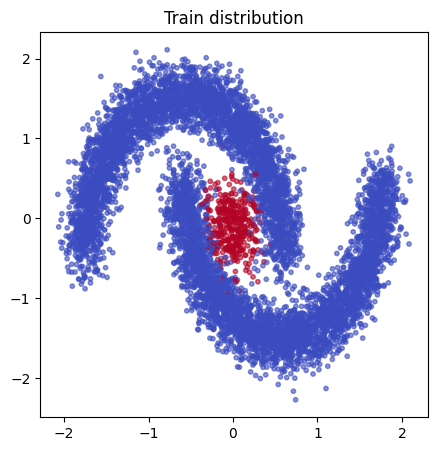

In [31]:
# Quick visual sanity check
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), s=10, cmap='coolwarm', alpha=0.6)
plt.title("Train distribution")
plt.show()

Notons que l'on choisit des centres pas trop éloignés pour que la tâche de classification soit non triviale et on verra que ca illustre bien l'intérêt de TarDiff.

### 3.3 Entraînement des modèles

D'après le pipeline TarDiff, il faut entraîner le **modèle downstream** pour pouvoir calculer le cache de gradients. Et le **modèle de diffusion** conditionnelle est aussi supposé entraîné sur le train.

C'est ce que l'on va faire dans cette section.

#### 3.3.1 Modèles et configurations

On définit d’abord les architectures minimales et les hyperparamètres d'entraînement.

In [32]:
# models 
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class SimpleClassifierV0(nn.Module):
    # linear classifier
    def __init__(self, input_dim=2, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class SimpleDiffusionNet(nn.Module):
    def __init__(self, t_dim=16):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(2 + t_dim + 1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.float())
        y_emb = y.view(-1, 1).float()
        x_in = torch.cat([x, t_emb, y_emb], dim=1)
        return self.net(x_in)


class DDPMScheduler:
    def __init__(self, num_timesteps=50, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t].view(-1, 1)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t].view(-1, 1)
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,)).to(self.device)


#### 3.3.2 Entraînement 

On entraîne d'abord le classifieur, puis le modèle de diffusion conditionnelle.

Commencons par définir les fonctions d'entraînement et d'évaluation pour les deux modèles.

In [33]:
# Training utils

@dataclass
class TrainConfig:
    clf_epochs: int = 30
    diff_epochs: int = 50
    clf_lr: float = 1e-3
    diff_lr: float = 1e-3
    timesteps: int = 50


def train_classifier(model, loader, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.clf_lr)
    crit = nn.CrossEntropyLoss()
    for _ in range(cfg.clf_epochs):
        for x, y in loader:
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()


def train_diffusion(model, loader, scheduler: DDPMScheduler, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.diff_lr)
    crit = nn.MSELoss()
    for _ in range(cfg.diff_epochs):
        for x, y in loader:
            opt.zero_grad()
            t = scheduler.sample_timesteps(x.shape[0]).view(-1, 1)
            x_t, noise = scheduler.noise(x, t)
            noise_pred = model(x_t, t, y)
            loss = crit(noise_pred, noise)
            loss.backward()
            opt.step()


def eval_classifier(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
    acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
    auroc = roc_auc_score(y.cpu().numpy(), probs.cpu().numpy())
    auprc = average_precision_score(y.cpu().numpy(), probs.cpu().numpy())
    return dict(acc=acc, auroc=auroc, auprc=auprc)


cfg_train = TrainConfig()
scheduler = DDPMScheduler(num_timesteps=cfg_train.timesteps, device=DEVICE)

Maintenant, on peut entraîner le classifieur downstream.

In [34]:
cfg_train_bal = TrainConfig()

clf_bal = SimpleClassifier().to(DEVICE)
train_classifier(clf_bal, train_loader, cfg_train_bal)
metrics_real_bal = eval_classifier(clf_bal, X_test, y_test)
print("Downstream on real :", metrics_real_bal)

Downstream on real : {'acc': 0.95, 'auroc': 0.9616842105263157, 'auprc': 0.6848606681256558}


Evidément, les performances sont très bonnes sur ce cas simple. 

Entraînons ensuite le modèle de diffusion conditionnelle sur le train.

In [35]:
# --- Training (Balanced 50/50) ---
scheduler_bal = DDPMScheduler(num_timesteps=cfg_train_bal.timesteps, device=DEVICE)

diff_model_bal = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model_bal, train_loader, scheduler_bal, cfg_train_bal)
print("Diffusion trained (balanced).")

Diffusion trained (balanced).


On vérifie que le DDPM conditionnel apprend correctement $p(x|y)$ sur le cas équilibré.

In [36]:
from scipy.stats import wasserstein_distance

def sample_standard(model, scheduler, n_samples, c):
    """Génération standard sans guidage (w=0) pour validation."""
    model.eval()
    with torch.no_grad():
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y = torch.full((n_samples,), c, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            noise_pred = model(x, t, y)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred) + torch.sqrt(beta) * noise
    return x


def check_distribution_metrics(real_samples, fake_samples, name=""):
    print(f"--- Check Distribution: {name} ---")
    
    mu_dist = torch.norm(real_samples.mean(dim=0) - fake_samples.mean(dim=0)).item()
    std_dist = torch.norm(real_samples.std(dim=0) - fake_samples.std(dim=0)).item()
    print(f"Diff Mean (L2): {mu_dist:.4f}")
    print(f"Diff Std  (L2): {std_dist:.4f}")
    
    wd0 = wasserstein_distance(real_samples[:,0].cpu().numpy(), fake_samples[:,0].cpu().numpy())
    wd1 = wasserstein_distance(real_samples[:,1].cpu().numpy(), fake_samples[:,1].cpu().numpy())
    print(f"Wasserstein Dist | Dim0: {wd0:.4f}, Dim1: {wd1:.4f}")
    
    return mu_dist, std_dist, wd0, wd1

Generating validation samples...
--- Check Distribution: Balanced Class 0 ---
Diff Mean (L2): 0.0318
Diff Std  (L2): 0.0416
Wasserstein Dist | Dim0: 0.0851, Dim1: 0.0415
--- Check Distribution: Balanced Class 1 ---
Diff Mean (L2): 0.0424
Diff Std  (L2): 0.0844
Wasserstein Dist | Dim0: 0.0722, Dim1: 0.0356


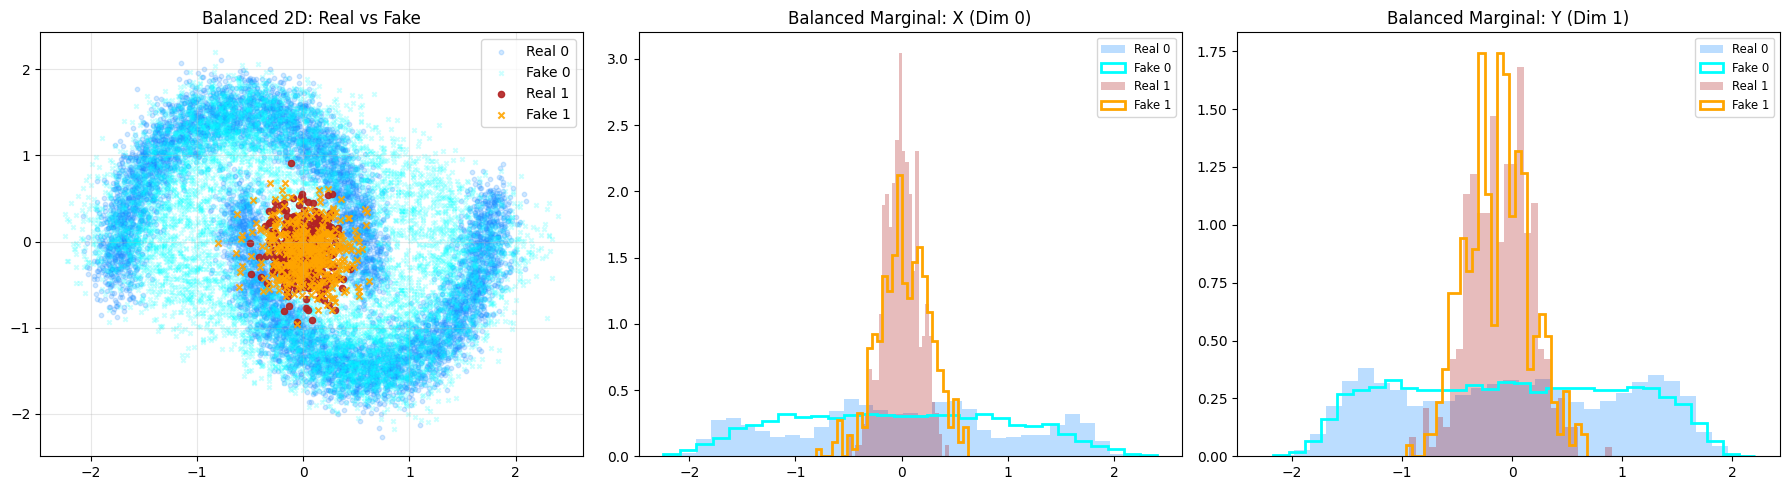

In [37]:
# --- Sanity Checks ---
print("Generating validation samples...")

X_maj_real_bal = X_train[y_train == 0]
X_maj_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_maj_real_bal), 0)

X_min_real_bal = X_train[y_train == 1]
X_min_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_min_real_bal), 1)

check_distribution_metrics(X_maj_real_bal, X_maj_gen_bal, "Balanced Class 0")
check_distribution_metrics(X_min_real_bal, X_min_gen_bal, "Balanced Class 1")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Balanced 2D: Real vs Fake")
axes[0].scatter(X_maj_real_bal[:,0].cpu(), X_maj_real_bal[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen_bal[:,0].cpu(), X_maj_gen_bal[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real_bal[:,0].cpu(), X_min_real_bal[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen_bal[:,0].cpu(), X_min_gen_bal[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Balanced Marginal: {name}")
    ax.hist(X_maj_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    ax.hist(X_maj_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    ax.hist(X_min_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    ax.hist(X_min_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

On voit que les échantillons générés sont relativement bien distribués même si les densités synthétiques ont tendance à s'attirer un peu plus que les vraies.

### 3.4 Génération ciblée par influence

A ce stade, on a quasiment tout ce qu'il faut pour faire de la génération ciblée par influence :
- on a le classifieur entraîné,
- on a le modèle de diffusion entraîné,

Il nous reste à calculer le cache de gradients $G$ à partir du guide set avant de pouvoir faire de la génération influencée. 

#### 3.4.1 Cache de gradients

Là, on rentre dans la spécificité de TarDiff : on calcule le cache de gradients $G$ à partir du guide set.

Pour rappel :

$$
G \;=\; \frac{1}{|\mathcal{D}_{\text{guide}}|}\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}\nabla_{\phi}\ell_T(x_g,y_g;\phi^*).
$$

En pratique, on **somme les gradients du classifieur** sur tout le guide set, puis on **normalise** ce vecteur global (L2). Ce cache sera ensuite utilisé dans le produit scalaire $\nabla_\phi \ell_T(x,y;\phi^*) \cdot G$ pour construire le terme de guidage.

In [38]:
# --- Influence Cache Computation ---

def _normalize_grads(grads, eps=1e-6):
    """L2 normalization across all parameter gradients (as in official code)."""
    total_norm = torch.sqrt(sum((g ** 2).sum() for g in grads))
    return [g / (total_norm + eps) for g in grads]

def compute_influence_cache(classifier, loader):
    classifier.eval()
    crit = nn.CrossEntropyLoss(reduction="sum")

    params = list(classifier.parameters())
    total_loss = torch.tensor(0.0, device=DEVICE)

    for x_g, y_g in loader:
        x_g, y_g = x_g.to(DEVICE), y_g.to(DEVICE)
        logits = classifier(x_g)
        total_loss += crit(logits, y_g)

    grads = torch.autograd.grad(total_loss, params, allow_unused=True) # compute gradients
    filtered = [(p, g) for p, g in zip(params, grads) if g is not None] # filter out None grads
    if not filtered:
        raise ValueError("No parameter received gradient!")

    filtered_params, filtered_grads = zip(*filtered) # unzip filtered parameters and gradients
    normed_grads = _normalize_grads(filtered_grads)

    G_cache = {
        name: g
        for (name, _), g in zip(classifier.named_parameters(), normed_grads) 
        if g is not None
    }
    return G_cache 


In [39]:
G_cache_bal = compute_influence_cache(clf_bal, guide_loader)
print("Influence cache norms :", {k: float(v.norm().item()) for k, v in G_cache_bal.items()})

Influence cache norms : {'net.0.weight': 0.5044213533401489, 'net.0.bias': 0.5249778032302856, 'net.2.weight': 0.45742902159690857, 'net.2.bias': 0.5106037259101868}


#### 3.4.2 Génération influencée

On a maintenant :
- le **modèle de diffusion conditionnel** entraîné,
- le **classifieur downstream**,
- le **cache de gradients $G$**.

On peut donc injecter le terme de guidage dans le reverse process pour obtenir une génération **orientée par l’influence**. Dans la suite, on implémente la fonction de sampling TarDiff qui ajoute $w\,J_t$ à la moyenne du DDPM.


In [40]:
# --- TarDiff Sampling ---

# This function implements guided DDPM sampling with an influence-based drift term.
# It follows the standard reverse diffusion loop and injects the TarDiff guidance J_t.

def tardiff_sample(model, scheduler, classifier, G_cache, n_samples=200, target_class=1, w=10.0):
    """
    J = grad_x [ <norm(grad_phi l(x,y)), norm(G)> ]
    """
    model.eval()
    classifier.eval()
    crit_clf = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        # Start from pure Gaussian noise and fix the target class.
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y_cond = torch.full((n_samples,), target_class, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            # Predict noise with the conditional diffusion model.
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            predicted_noise = model(x, t, y_cond)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            # Compute the DDPM mean (x_recon) and the standard noise term.
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x_recon = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise)
            
            # Compute the influence-guidance direction J_t (if w != 0).
            J = torch.zeros_like(x)
            if w != 0:  # Apply influence guidance
                with torch.enable_grad():
                    x_in = x.detach().clone()
                    x_in.requires_grad = True
                    
                    out_clf = classifier(x_in)
                    loss = crit_clf(out_clf, y_cond)
                    
                    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, allow_unused=True)
                    filtered = [(p, g) for p, g in zip(classifier.parameters(), grads_phi) if g is not None]
                    if not filtered:
                        raise ValueError("No parameter received gradient!")
                    _, grads_phi = zip(*filtered)
                    grads_phi = _normalize_grads(grads_phi)
                    
                    # Influence score = dot product between per-sample grads and cached G.
                    influence_score = 0
                    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
                        if name in G_cache:
                            influence_score += torch.sum(g_phi * G_cache[name])  # dot product

                    # J_t is the gradient of the influence score w.r.t. x.
                    J = torch.autograd.grad(influence_score, x_in)[0]
                
                J = J.detach()
            
            # Final update: DDPM mean + guidance drift + noise.
            sigma_t = torch.sqrt(beta)
            x = x_recon + (w * J) + sigma_t * noise
            
    return x.detach()


Pour visualiser l'apport de la méthode, on va afficher les échantillons générés pour différentes valeurs de $w$, en les comparant aux vraies données d'entraînement pour les deux classes.

Sampling 5000 points per w (balanced)...


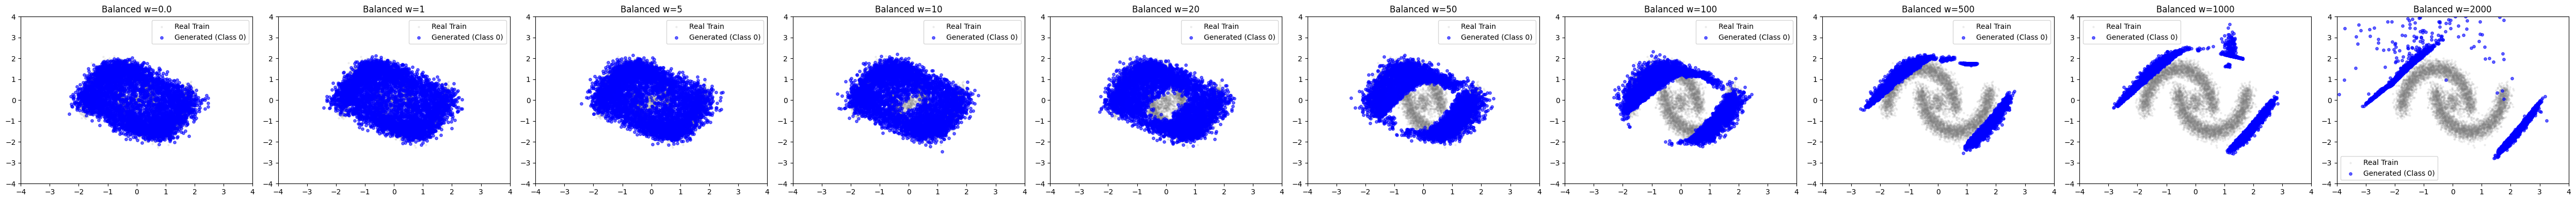

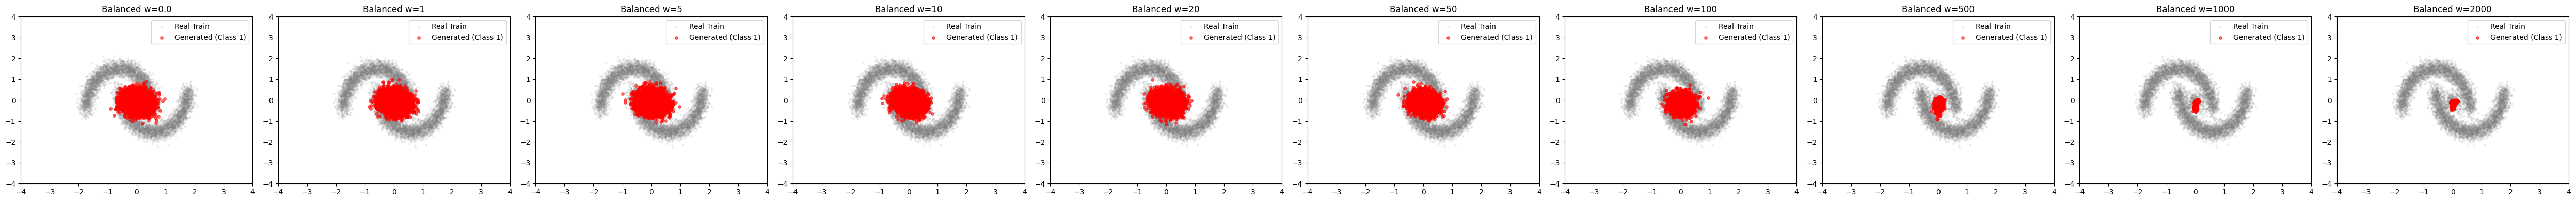

In [69]:
# --- Guidance Sweep ---
N_GEN_BAL = 5000
w_values_bal = [0.0, 1, 5, 10, 20, 50, 100, 500, 1000, 2000]
print(f"Sampling {N_GEN_BAL} points per w (balanced)...")

def guidance_sweep(model, scheduler, classifier, G_cache, w_values, n_samples, target_class):
    samples_by_w = {}
    for w in w_values:
        samples_by_w[w] = tardiff_sample(model, scheduler, classifier, G_cache, n_samples=n_samples, target_class=target_class, w=w)
    return samples_by_w

samples_bal_0 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf_bal,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=0
)

def plot_res_with_train(X_train_ref, samples, title, color, class_label, ax):
    ax.scatter(X_train_ref[:, 0].cpu(), X_train_ref[:, 1].cpu(), c='gray', s=5, alpha=0.1, label='Real Train')
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), c=color, s=15, alpha=0.6, label=f'Generated (Class {class_label})')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_0[w], f"Balanced w={w}", "blue", 0, ax)
plt.tight_layout()
plt.show()

samples_bal_1 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf_bal,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=1
)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_1[w], f"Balanced w={w}", "red", 1, ax)
plt.tight_layout()
plt.show()

Analyse Visuelle : 

On observe l'évolution des distributions générées (Bleu pour la classe majoritaire, Rouge pour la minoritaire) à mesure que le poids de guidance $w$ augmente (de gauche à droite)

- À faible guidance ($w=0$ à $5$) : Les points générés (bleus et rouges) recouvrent relativement fidèlement (limité par la précision du modèle de diffusion) la distribution réelle (en gris). Le modèle agit comme un générateur classique (DDPM) et préserve la variance et la forme des données.
- À forte guidance ($w \geq 100$) : On observe une distorsion spectaculaire.
    - Classe 0 (Bleu) : Les points sont repoussés loin de la frontière de décision centrale. La forme en "double lune" est brisée pour former des lignes denses dans les zones de "sécurité maximale".
    - Classe 1 (Rouge) : Le cluster s'effondre sur lui-même (mode collapse). Il devient une singularité ultra-dense au centre de la zone minoritaire
    
> Interprétation : Ceci illustre parfaitement le mécanisme de TarDiff. Le gradient $\nabla_{\phi}l$ ne pousse pas le modèle à être réaliste, mais classifiable. Pour minimiser la perte, le moyen le plus efficace est de générer des "super-prototypes" : des exemples caricaturaux, sans aucune ambiguïté, situés le plus loin possible de la frontière de décision adverse.

Note : ça peut paraître contre intuitif au premier abord, puisque l'on pourrait s'attendre à ce que les points soient justement poussés vers la frontière de décision pour maximiser l'information et aider le classifieur. 

### 3.7 Utilité downstream 

On mesure l'utilité des échantillons synthétiques pour la tâche downstream (classification binaire) de deux manières : 
- TSTR - Training on Synthetic, Testing on Real : on entraîne un classifieur sur les données synthétiques générées, puis on l'évalue sur le test set réel.
- TSRTR - Training on Synthetic + Real, Testing on Real : on entraîne un classifieur sur les données réelles augmentées des données synthétiques générées, puis on l'évalue sur le test set réel.

In [82]:
# --- Downstream Utility (Balanced 50/50): TSTR ---
print("\n--- Downstream Utility (Balanced 50/50) - TSTR ---")

import pandas as pd

# Train classifiers per w on synthetic-only data (single run)
rows_tstr = [{
    "w": "real-only",
    "acc": metrics_real_bal["acc"],
    "auroc": metrics_real_bal["auroc"],
    "auprc": metrics_real_bal["auprc"],
}]
results_tstr_bal = {}
preds_tstr = {}

for w in w_values_bal:
    X_syn_0 = samples_bal_0[w]
    X_syn_1 = samples_bal_1[w]

    y_syn_0 = torch.zeros(len(X_syn_0), dtype=torch.long).to(DEVICE)
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)

    X_syn = torch.cat([X_syn_0, X_syn_1])
    y_syn = torch.cat([y_syn_0, y_syn_1])

    loader_syn = DataLoader(TensorDataset(X_syn, y_syn), batch_size=64, shuffle=True)
    clf_syn = SimpleClassifier().to(DEVICE)
    train_classifier(clf_syn, loader_syn, TrainConfig(clf_epochs=30))
    metrics_syn = eval_classifier(clf_syn, X_test, y_test)

    with torch.no_grad():
        logits = clf_syn(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu()
        preds = torch.argmax(logits, dim=1).detach().cpu()

    preds_tstr[w] = {"preds": preds, "probs": probs}
    results_tstr_bal[w] = metrics_syn

    rows_tstr.append({
        "w": w if w != 0.0 else "DDPM",
        "acc": metrics_syn["acc"],
        "auroc": metrics_syn["auroc"],
        "auprc": metrics_syn["auprc"],
    })

results_tstr_df = pd.DataFrame(rows_tstr)
best_w_tstr = max(results_tstr_bal, key=lambda k: results_tstr_bal[k]["auroc"])
best_preds_tstr = preds_tstr[best_w_tstr]["preds"]
best_probs_tstr = preds_tstr[best_w_tstr]["probs"]

# Display as table (one row per w)
results_tstr_df


--- Downstream Utility (Balanced 50/50) - TSTR ---


,w,acc,auroc,auprc
0,real-only,0.9500,0.961684,0.684861
1,DDPM,0.8835,0.992195,0.900076
2,1,0.8970,0.993121,0.909205
3,5,0.8650,0.992347,0.902755
4,10,0.8860,0.991205,0.885166
5,20,0.8595,0.991153,0.879713
6,50,0.7885,0.989242,0.876106
7,100,0.7435,0.975874,0.780918
8,500,0.6790,0.933232,0.290959
9,1000,0.6505,0.892547,0.190361


TSTR: best w = 1 (AUROC=0.9926)


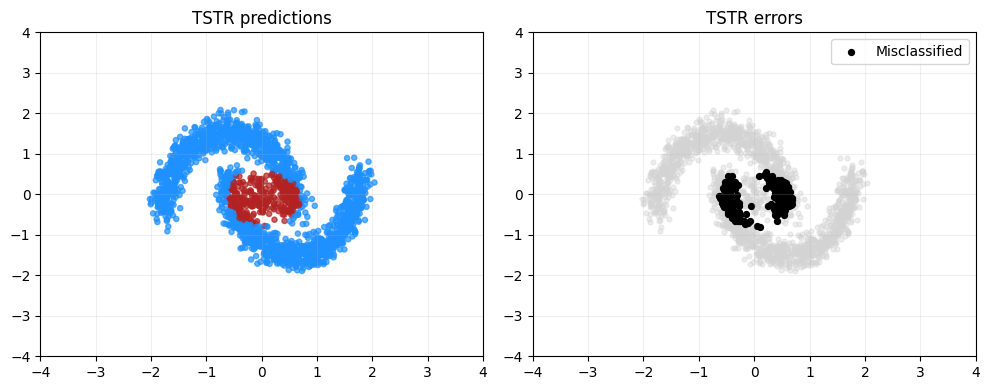

In [71]:
# --- TSTR predictions visualization (best w) ---
print(f"TSTR: best w = {best_w_tstr} (AUROC={results_tstr_bal[best_w_tstr]['auroc']:.4f})")

X_test_cpu = X_test.detach().cpu()
y_test_cpu = y_test.detach().cpu()
preds = best_preds_tstr
errors = preds != y_test_cpu

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = np.where(preds.numpy() == 1, "firebrick", "dodgerblue")
axes[0].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c=colors, s=14, alpha=0.7)
axes[0].set_title("TSTR predictions")
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].grid(alpha=0.2)

axes[1].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c="lightgray", s=12, alpha=0.4)
axes[1].scatter(X_test_cpu[errors][:, 0], X_test_cpu[errors][:, 1], c="black", s=18, label="Misclassified")
axes[1].set_title("TSTR errors")
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

Comme on le voyait sur les plots $w=1000$ ou $2000$, les données synthétiques perdent progressivement toute leur diversité (variance faible) et la ressemblance avec les données réelles. Un classifieur entraîné uniquement sur ces "caricatures" rouges et bleues n'apprend jamais à gérer les cas limites ou le bruit des données réelles. 

Résultat : Quand on le teste sur le réel, il échoue (Accuracy chute de 0.95 à 0.59).

Par contre, on remarque que pour des valeurs intermédiaires de $w$ l'AUROC et l'AUPRC explosent (> 0.99 pour l'AUC et > 0.87 pour l'AUPRC contre 0.96 et 0.68 respectivement sur les vraies données). Ce n'est pas du tout incohérent avec la dégradation de l'accuracy puisque ce sont des mesures de ranking (ordre). Elles évaluent si le modèle est capable de classer un exemple positif plus haut qu'un exemple négatif, quel que soit le score exact.

Sur un dataset déséquilibré (95% / 5%), un modèle qui prédit "Toujours Classe 0" a une accuracy de 95%. Il a une haute accuracy mais il est inutile pour détecter la classe rare (d'où l'AUPRC faible). Ici, on force au classifieur à apprendre les caractéristiques distinctives de la classe minoraitaire, sortant le classifieur de son biais majoritaire. 

> Observation partielle : Tardiff semble très efficace pour maximiser la détectabilité (ranking) des événements rares, au prix d'une perte de précision sur la frontière de décision exacte.

Testons maintenant l'impact de l'augmentation avec les données synthétiques sur un entraînement mixte (TSRTR).

In [72]:
# --- Downstream Utility (Balanced 50/50): TSRTR ---
print("\n--- Downstream Utility (Balanced 50/50) - TSRTR ---")

import pandas as pd

# Train classifiers per w on train + synthetic data (single run)
rows_tsrtr = [{
    "w": "real-only",
    "acc": metrics_real_bal["acc"],
    "auroc": metrics_real_bal["auroc"],
    "auprc": metrics_real_bal["auprc"],
}]
results_tsrtr_bal = {}
preds_tsrtr = {}

for w in w_values_bal:
    X_syn_0 = samples_bal_0[w]
    X_syn_1 = samples_bal_1[w]

    y_syn_0 = torch.zeros(len(X_syn_0), dtype=torch.long).to(DEVICE)
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)

    X_syn = torch.cat([X_syn_0, X_syn_1])
    y_syn = torch.cat([y_syn_0, y_syn_1])

    X_aug = torch.cat([X_train, X_syn])
    y_aug = torch.cat([y_train, y_syn])

    loader_aug = DataLoader(TensorDataset(X_aug, y_aug), batch_size=64, shuffle=True)
    clf_aug = SimpleClassifier().to(DEVICE)
    train_classifier(clf_aug, loader_aug, TrainConfig(clf_epochs=30))
    metrics_aug = eval_classifier(clf_aug, X_test, y_test)

    with torch.no_grad():
        logits = clf_aug(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu()
        preds = torch.argmax(logits, dim=1).detach().cpu()

    preds_tsrtr[w] = {"preds": preds, "probs": probs}
    results_tsrtr_bal[w] = metrics_aug

    rows_tsrtr.append({
        "w": w,
        "acc": metrics_aug["acc"],
        "auroc": metrics_aug["auroc"],
        "auprc": metrics_aug["auprc"],
    })

results_tsrtr_df = pd.DataFrame(rows_tsrtr)
best_w_tsrtr = max(results_tsrtr_bal, key=lambda k: results_tsrtr_bal[k]["auroc"])
best_preds_tsrtr = preds_tsrtr[best_w_tsrtr]["preds"]
best_probs_tsrtr = preds_tsrtr[best_w_tsrtr]["probs"]

# Display as table (one row per w)
results_tsrtr_df


--- Downstream Utility (Balanced 50/50) - TSRTR ---


,w,acc,auroc,auprc
0,real-only,0.9500,0.961684,0.684861
1,0.0,0.9600,0.995179,0.932452
2,1,0.9570,0.995211,0.931149
3,5,0.9575,0.995116,0.929290
4,10,0.9595,0.995037,0.925463
5,20,0.9600,0.995679,0.932526
6,50,0.9640,0.995782,0.934746
7,100,0.9720,0.996068,0.935837
8,500,0.9885,0.995295,0.940092
9,1000,0.9885,0.995347,0.945948


TSRTR: best w = 2000 (AUROC=0.9963)


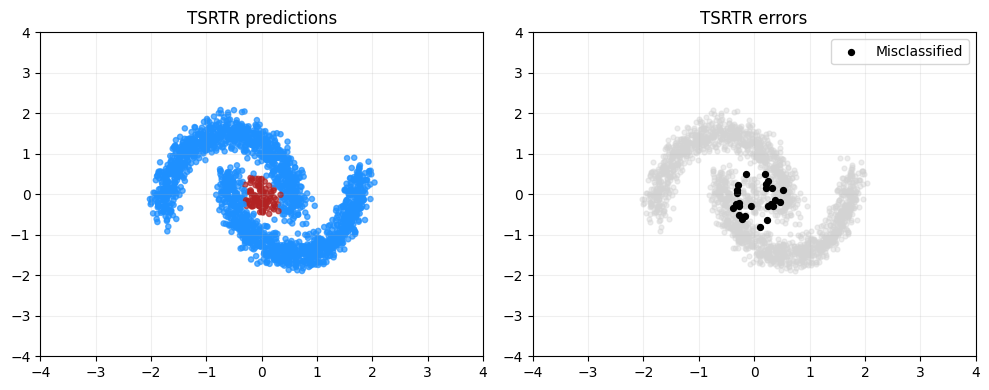

In [73]:
# --- TSRTR predictions visualization (best w) ---
print(f"TSRTR: best w = {best_w_tsrtr} (AUROC={results_tsrtr_bal[best_w_tsrtr]['auroc']:.4f})")

X_test_cpu = X_test.detach().cpu()
y_test_cpu = y_test.detach().cpu()
preds = best_preds_tsrtr
errors = preds != y_test_cpu

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = np.where(preds.numpy() == 1, "firebrick", "dodgerblue")
axes[0].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c=colors, s=14, alpha=0.7)
axes[0].set_title("TSRTR predictions")
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].grid(alpha=0.2)

axes[1].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c="lightgray", s=12, alpha=0.4)
axes[1].scatter(X_test_cpu[errors][:, 0], X_test_cpu[errors][:, 1], c="black", s=18, label="Misclassified")
axes[1].set_title("TSRTR errors")
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

C'est là où l'on voit tout l'intérêt de TarDiff !

Contrairement à l'expérience précédente (TSTR) où le remplacement total des données réelles entraînait une perte de calibration (chute d'Accuracy), l'ajout de données synthétiques aux données réelles (Augmentation) produit ici les meilleurs résultats absolus.

**Le "Meilleur des Deux Mondes"**
- Accuracy (Exactitude) : Elle ne chute plus, elle augmente ! Elle passe de 0.957 ($w=0$, baseline) à près de 0.990 ($w=500$). 
- AUPRC / AUROC : Elles sont extrêment élevées (> 0.94 pour l'AUPRC et > 0.995 pour l'AUROC).

Ces deux métriques d'AUPRC et d'AUROC sont particulièrement importantes dans les contextes médicaux déséquilibrés, car elles reflètent la capacité du modèle à détecter correctement les cas rares sans être influencé par la majorité des cas négatifs.

**Pourquoi l'Accuracy remonte-t-elle ici ?**

C'est l'effet correctif des données réelles : Les données synthétiques (TarDiff) agissent comme des "ancres" ou des "Super-Exemples". Elles sont caricaturales et forcent le modèle à créer une frontière de décision très nette autour de la classe minoritaire. Les données réelles apportent la "variance" et le "bruit" nécessaires. Elles empêchent le modèle d'être trop rigide (overconfident) et lui apprennent à gérer les cas limites flous. Et on remarque que plus le traît est tiré i.e plus $w$ est grand (même à 2000), plus l'accuracy remonte.

**Conclusion**

TarDiff ne doit pas être vu comme un outil de remplacement de données (anonymisation parfaite), mais comme un outil d'optimisation de l'utilité clinique. Il transforme le processus de génération : au lieu de simplement imiter la réalité (qui contient des biais et des déséquilibres), il la distord intelligemment pour maximiser la performance diagnostique sur les cas qui comptent le plus

### 3.8 Analyse de la méthode et des hyperparamètres

Maintenant que nous avons validé le pipeline Tardiff et montré son intérêt dans le cas déséquilibré, nous allons faire quelques analyses supplémentaires notamment sur le choix des hyperparamètres, avant d'appliquer la méthode sur des données ECG réelles.

# TODO : 
finir la section 3 en analysant :
- l'impact de la proportions de données synthétiques dans le TSRTR.
- l'impact du choix du guide set (minority, majority, mixte)
- analyser le gradient de guidance J_t pour comprendre son comportement
- analyser la différence de gradient par classe (majority vs minority)

faire la section 4 sur les données ECG réelles